<a href="https://colab.research.google.com/github/swjh9523/Python_Tutorial/blob/master/%EC%BD%94%EB%A1%9C%EB%82%98_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


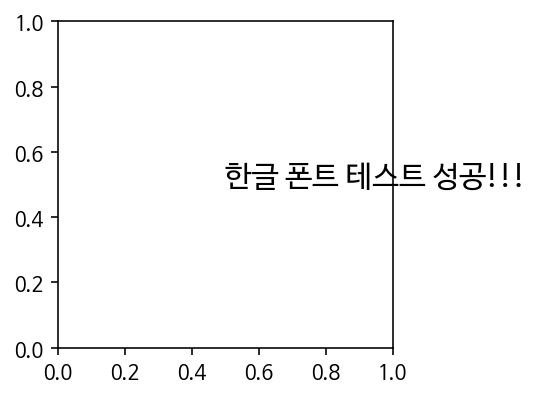

In [ ]:
# 그래프 한글폰트 사용설정 in Colab
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

fontpath = '/content/drive/My Drive/파이썬/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

## Test
plt.figure(figsize=(3,3))
plt.text(0.5, 0.5, '한글 폰트 테스트 성공!!!', size=15)
plt.show()

In [ ]:
card = pd.read_csv('/content/drive/MyDrive/공모전데이터파일/COVID-19/card_20200717.csv', encoding="UTF-8")
card.head(1)

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,20200104,1174066000,성내3동,7041,약국,463,5843230


In [ ]:
card.columns = ["접수일자","행정동 코드", "행정동 명", "업종 코드", "업종 명", "발생 건수", "발생 금액"]

In [ ]:
card.columns

Index(['접수일자', '행정동 코드', '행정동 명', '업종 코드', '업종 명', '발생 건수', '발생 금액'], dtype='object')

In [ ]:
card.head()

,접수일자,행정동 코드,행정동 명,업종 코드,업종 명,발생 건수,발생 금액
0,20200104,1174066000,성내3동,7041,약국,463,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000


In [ ]:
card["접수 연도"] = card["접수일자"].astype('str').apply(lambda x : x[:4])
card["접수 월일"] = card["접수일자"].astype('str').apply(lambda x : x[4:6]+'-'+x[6:])
card["접수 연도"] = card["접수 연도"].astype('int')

In [ ]:
card["접수 연도"].dtype

dtype('int64')

In [ ]:
card.head()

,접수일자,행정동 코드,행정동 명,업종 코드,업종 명,발생 건수,발생 금액,접수 연도,접수 월일
0,20200104,1174066000,성내3동,7041,약국,463,5843230,2020,01-04
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550,2020,01-04
2,20200104,1174066000,성내3동,7021,한의원,53,4589800,2020,01-04
3,20200104,1174066000,성내3동,7020,의원,339,9267240,2020,01-04
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000,2020,01-04


In [ ]:
card1 = card.drop(["접수일자","행정동 코드"],axis=1).copy()

In [ ]:
card1.head()

,행정동 명,업종 코드,업종 명,발생 건수,발생 금액,접수 연도,접수 월일
0,성내3동,7041,약국,463,5843230,2020,01-04
1,성내3동,7022,치과의원,33,7835550,2020,01-04
2,성내3동,7021,한의원,53,4589800,2020,01-04
3,성내3동,7020,의원,339,9267240,2020,01-04
4,성내3동,6110,자동차정비,19,4441000,2020,01-04


In [ ]:
card1["행정동 명"].unique()

array(['성내3동', '성내2동', '성내1동', '천호3동', '천호2동', '천호1동', '암사3동', '암사2동',
       '암사1동', '고덕2동', '고덕1동', '명일2동', '명일1동', '상일동', '강일동', '잠실7동',
       '잠실6동', '잠실4동', '잠실3동', '잠실2동', '잠실본동', '위례동', '장지동', '문정2동',
       '문정1동', '가락2동', '가락1동', '가락본동', '삼전동', '석촌동', '송파2동', '송파1동',
       '오금동', '오륜동', '방이2동', '방이1동', '마천2동', '마천1동', '거여2동', '거여1동',
       '풍납2동', '풍납1동', '수서동', '일원2동', '일원1동', '일원본동', '세곡동', '개포4동',
       '개포2동', '도곡2동', '도곡1동', '역삼2동', '역삼1동', '대치4동', '대치2동', '대치1동',
       '삼성2동', '삼성1동', '청담동', '압구정동', '논현2동', '논현1동', '신사동', '내곡동',
       '양재2동', '양재1동', '방배4동', '방배3동', '방배2동', '방배1동', '방배본동', '반포4동',
       '반포3동', '반포2동', '반포1동', '반포본동', '잠원동', '서초4동', '서초3동', '서초2동',
       '서초1동', '난곡동', '미성동', '삼성동', '대학동', '조원동', '난향동', '신림동', '서림동',
       '신원동', '서원동', '남현동', '인헌동', '중앙동', '은천동', '청룡동', '낙성대동', '행운동',
       '성현동', '청림동', '보라매동', '신대방2동', '신대방1동', '대방동', '사당5동', '사당4동',
       '사당3동', '사당2동', '사당1동', '흑석동', '상도4동', '상도3동', '상도2동', '상도1동',
       '노량진2동', '노량진1동

In [ ]:
양천구 = card1[card1["행정동 명"].str.contains('신월|신정|목1동|목2동|목3동|목4동|목5동')].copy()
양천구["행정동 명"].unique()
양천구 = 양천구[~양천구["행정동 명"].str.startswith('면목')].copy()
양천구.head()

,행정동 명,업종 코드,업종 명,발생 건수,발생 금액,접수 연도,접수 월일
4235,신정7동,9305,학원(회원제형태),16,6144000,2020,01-04
4236,신정7동,8399,기타음료식품,65,715150,2020,01-04
4237,신정7동,8302,정 육 점,24,7555400,2020,01-04
4238,신정7동,8301,제과점,174,2070840,2020,01-04
4239,신정7동,8021,스넥,188,2481500,2020,01-04


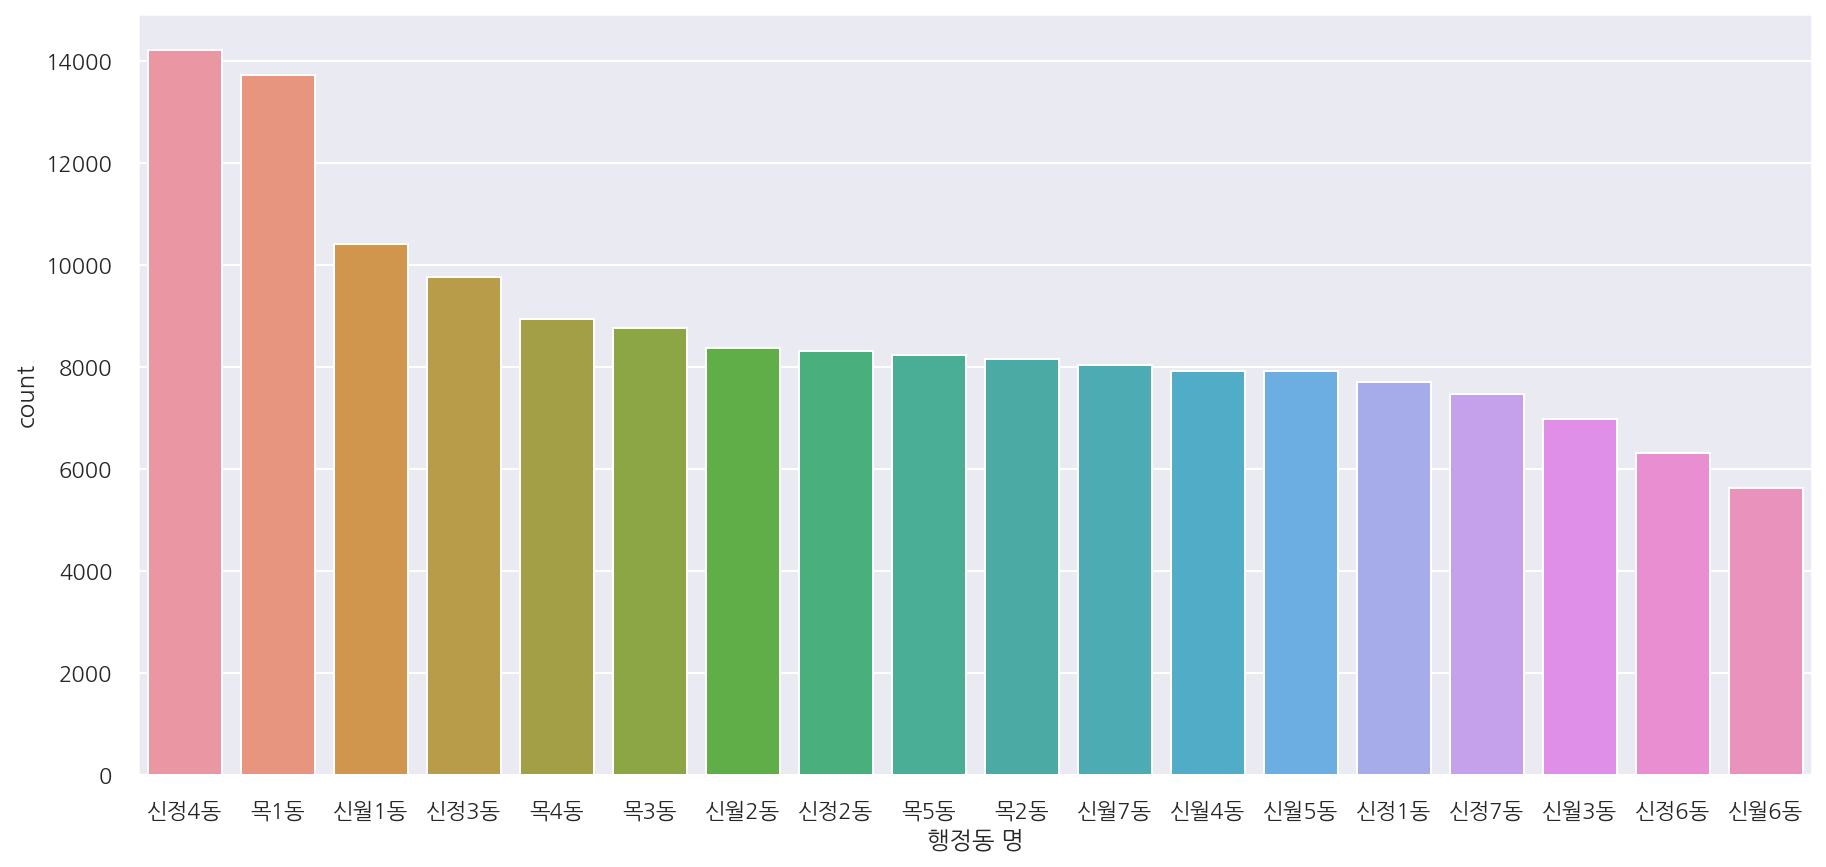

In [ ]:
sns.set(font="NanumGothic", 
         rc={"axes.unicode_minus":False},
         style='darkgrid')
plt.figure(figsize = (15,7))
sns.countplot(data=양천구, x= "행정동 명", order=양천구["행정동 명"].value_counts().index)

In [ ]:
card1["업종 명"].value_counts()

일반한식         65528
서양음식         65499
편 의 점        65160
스넥           65007
미 용 원        64073
             ...  
통신기기무이자할부        8
카지노              8
택시회사             4
P2P송금            2
중고자동차위탁판매        1
Name: 업종 명, Length: 260, dtype: int64

In [ ]:
card2 = card1[["업종 코드","업종 명"]].unstack().copy()

In [ ]:
card2.sort_values(by='업종 코드', ascending=False)

,업종 코드,업종 명
372186,9998,기타전문점
794722,9998,기타전문점
2768005,9998,기타전문점
1167767,9998,기타전문점
2067809,9998,기타전문점
...,...,...
494828,1001,특급 호텔
2791162,1001,특급 호텔
1838837,1001,특급 호텔
1542791,1001,특급 호텔


KeyError: ignored

In [ ]:
양천구.head()

,행정동 명,업종 코드,업종 명,발생 건수,발생 금액,접수 연도,접수 월일
4235,신정7동,9305,학원(회원제형태),16,6144000,2020,01-04
4236,신정7동,8399,기타음료식품,65,715150,2020,01-04
4237,신정7동,8302,정 육 점,24,7555400,2020,01-04
4238,신정7동,8301,제과점,174,2070840,2020,01-04
4239,신정7동,8021,스넥,188,2481500,2020,01-04


In [ ]:
양천구['업종 코드'] = 양천구["업종 코드"].astype('str')

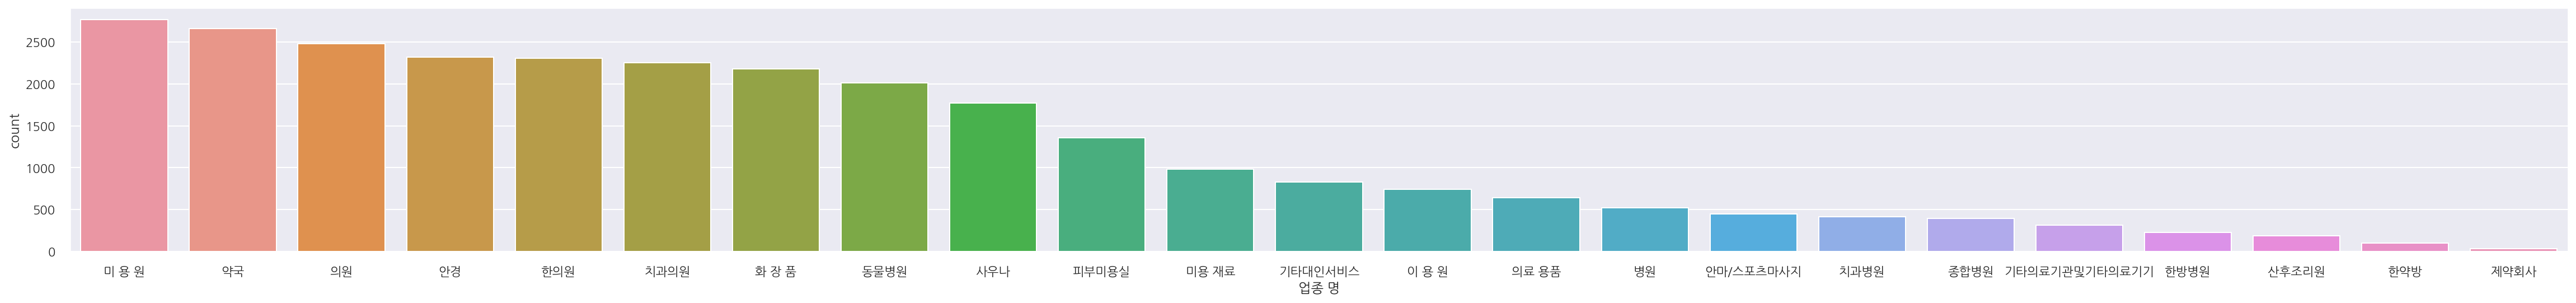

In [ ]:
count = 양천구[양천구['업종 코드'].str.startswith('7')]["업종 코드"].value_counts()
양천구_7 = 양천구[양천구['업종 코드'].str.startswith('7')].copy()
plt.figure(figsize=(40,4))
sns.countplot(data=양천구_7, x="업종 명", order=양천구_7["업종 명"].value_counts().index)

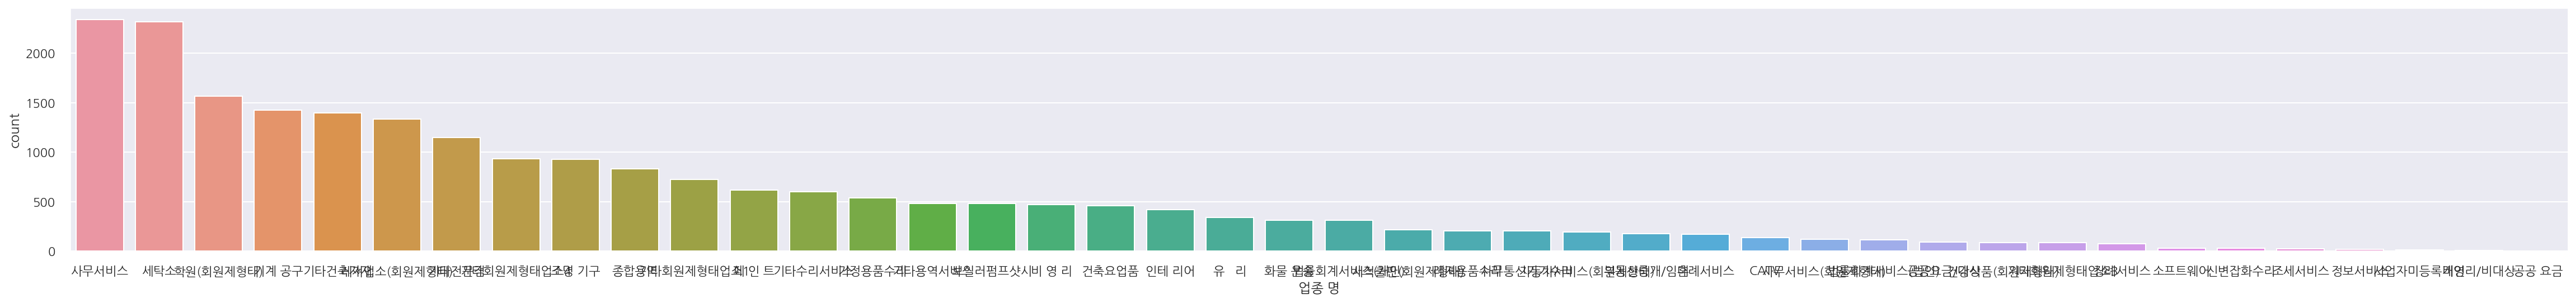

In [ ]:
양천구_9 = 양천구[양천구['업종 코드'].str.startswith('9')].copy()
plt.figure(figsize=(40,4))
sns.countplot(data=양천구_9, x="업종 명", order=양천구_9["업종 명"].value_counts().index)

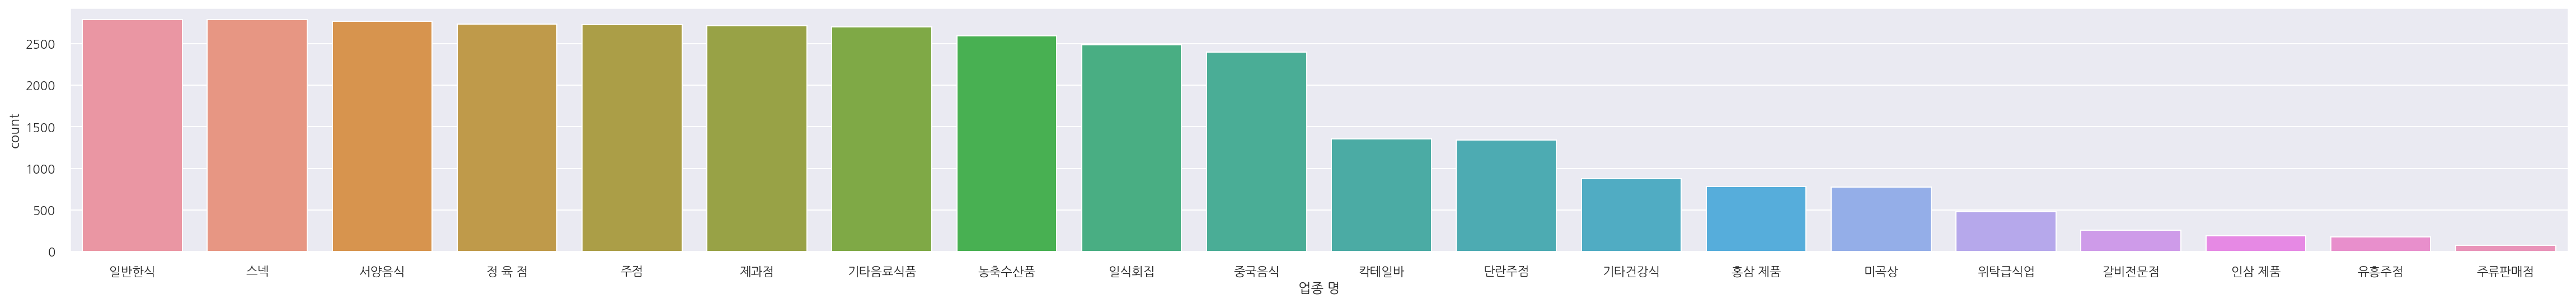

In [ ]:
양천구_8 = 양천구[양천구['업종 코드'].str.startswith('8')].copy()
plt.figure(figsize=(40,4))
sns.countplot(data=양천구_8, x="업종 명", order=양천구_8["업종 명"].value_counts().index)

In [ ]:
양천구_7.head()

,행정동 명,업종 코드,업종 명,발생 건수,발생 금액,접수 연도,접수 월일
4244,신정7동,7102,미 용 원,43,1720000,2020,01-04
4245,신정7동,7041,약국,190,2610210,2020,01-04
4246,신정7동,7022,치과의원,21,2130900,2020,01-04
4247,신정7동,7021,한의원,29,1085700,2020,01-04
4248,신정7동,7020,의원,133,2390300,2020,01-04


In [ ]:
양천구_코드 = 양천구[["업종 코드","업종 명"]].copy()